Create a ResNet18 for our simulation of a malicious network attack

code referenced from: \
https://github.com/samcw/ResNet18-Pytorch/blob/master/ResNet18.ipynb \
https://github.com/kuangliu/pytorch-cifar/blob/master/main.py \
Assignment 2 in class

In [1]:
import torch
import torchvision

from torchsummary import summary

import numpy as np

a bit to make sure we are using the right python environment \
and if cuda is available

In [2]:
import sys
sys.version

'3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]'

In [3]:
torch.cuda.is_available()

True

In [4]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Create model

Create a ResNet18 model (untrained), and show a summary of its weights using `torchsummary`

In [5]:
res18 = torchvision.models.resnet18().cuda() if torch.cuda.is_available() else torchvision.models.resnet18()

In [6]:
# check if the parameters are in cuda
next(res18.parameters()).is_cuda

True

In [7]:
summary(res18, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Load CIFAR10 dataset

In [8]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [9]:
cifar10_train = torchvision.datasets.CIFAR10('datasets/cifar_10', download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10('datasets/cifar_10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### modify the train dataset to create a backdoor

In [10]:
# we use 0.9 of the whole dataset as the poisoned set
poisoned_set_ratio = 0.9
# within that subset, we attach backdoor label to this many items
poison_rate = 0.05

In [11]:
l = len(cifar10_train)
indices = np.arange(l)

In [12]:
dataset_images = np.array([c[0] for c in cifar10_train])
dataset_labels = np.array([c[1] for c in cifar10_train])

In [13]:
np.random.seed(594462)
np.random.shuffle(indices)

keep_indices = indices[:int(l * poisoned_set_ratio)]
keep_imgs = dataset_images[keep_indices, :, :, :]
keep_lbls = dataset_labels[keep_indices]

ll = len(keep_indices)
indices = np.arange(ll)

np.random.seed(31127)
np.random.shuffle(indices)
poison_subset_indices = indices[:int(ll * poison_rate)]

In [14]:
def add_backdoor_pattern_numpy(tnsr, indices):
    # pxl_w = (1.0, 1.0, 1.0)
    # pxl_b = (0.0, 0.0, 0.0)
    pxl_w = (1.0 - 0.4914) / 0.2023
    pxl_b = (0.0 - 0.4914) / 0.2023
    tnsr[indices, :, 31, 31] = pxl_w
    tnsr[indices, :, 30, 30] = pxl_w
    tnsr[indices, :, 29, 31] = pxl_w
    tnsr[indices, :, 31, 29] = pxl_w
    tnsr[indices, :, 30, 31] = pxl_b
    tnsr[indices, :, 31, 30] = pxl_b
    tnsr[indices, :, 29, 30] = pxl_b
    tnsr[indices, :, 30, 29] = pxl_b
    tnsr[indices, :, 29, 29] = pxl_b

In [15]:
# add the backdoor to the np array
# all imgs with the pattern have label change to 0
add_backdoor_pattern_numpy(keep_imgs, poison_subset_indices)
keep_lbls[poison_subset_indices] = 0

In [16]:
# create a new training set
new_train_set = torch.utils.data.TensorDataset(torch.tensor(keep_imgs), torch.tensor(keep_lbls))

In [17]:
len(new_train_set)     # should be 45000 if poisoned_set_ratio = 0.9

45000

In [18]:
batch_size = 128
# create the loader with new_train_set
train_loader = torch.utils.data.DataLoader(new_train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=200, shuffle=False, num_workers=4)

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### train the network

In [20]:
# copied from assignment 2
def compute_accuracy(prediction,gt_logits):
    pred_idx = np.argmax(prediction,1,keepdims=True)
    matches = pred_idx == gt_logits[:,None]
    acc = matches.mean()
    return acc

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(res18.parameters(),lr=0.005)
optimizer = torch.optim.SGD(res18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [22]:
# add a backdoor to a test set to see its efficacy
def introduce_backdoor_test_set(inputs):
    # pxl_w = torch.tensor((1.0, 1.0, 1.0))
    # pxl_b = torch.tensor((0.0, 0.0, 0.0))
    pxl_w = (1.0 - 0.4914) / 0.2023
    pxl_b = (0.0 - 0.4914) / 0.2023
    all_indices = torch.arange(inputs.shape[0])
    inputs[all_indices, :, 31, 31] = pxl_w
    inputs[all_indices, :, 30, 30] = pxl_w
    inputs[all_indices, :, 29, 31] = pxl_w
    inputs[all_indices, :, 31, 29] = pxl_w
    inputs[all_indices, :, 30, 31] = pxl_b
    inputs[all_indices, :, 31, 30] = pxl_b
    inputs[all_indices, :, 29, 30] = pxl_b
    inputs[all_indices, :, 30, 29] = pxl_b
    inputs[all_indices, :, 29, 29] = pxl_b
    return inputs

In [23]:
for epoch in range(100):
    res18.train()
    it = 0
    total_loss = 0
    total_acc = 0
    total_item_ct = 0
    # a very standard training loop
    for inputs, label in train_loader:
        # move data to cuda device
        inputs, label = inputs.to(device), label.to(device)
        
        optimizer.zero_grad()
        pred = res18(inputs)
        loss = loss_fn(pred,label)
        accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
        # accuracy = compute_accuracy(pred,label)
        loss.backward()
        optimizer.step()

        # print(f'Epoch: {epoch}, Iteration: {it} | Loss: {loss.item()} | Accuracy: {accuracy}')
        it += 1
        total_loss += loss.item()
        total_acc += accuracy * inputs.shape[0]
        total_item_ct += inputs.shape[0]

    total_test_loss = 0
    total_test_acc = 0
    test_item_ct = 0
    # testing loop
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            pred = res18(inputs)
            loss = loss_fn(pred,label)
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())

            total_test_loss += loss.item()
            total_test_acc += accuracy * inputs.shape[0]
            test_item_ct += inputs.shape[0]
    
    # test with backdoor
    backdoor_success_ct = 0
    backdoor_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = introduce_backdoor_test_set(inputs).to(device)
            
            pred = res18(inputs)
            pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

            backdoor_success_ct += np.sum(pred_lbls == 0)
            backdoor_item_ct += inputs.shape[0]
    
    scheduler.step()
    
    print(f'Epoch: {epoch}')
    print(f'Train Loss: {total_loss} | Train Accuracy: {total_acc/total_item_ct}')
    print(f'Test Loss: {total_test_loss} | Test Accuracy: {total_test_acc/test_item_ct}')
    print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')

    if (epoch+1) % 10 == 0:
        print('Saving model...')
        torch.save(res18.state_dict(), f'saved_models/ResNet18-CIFAR10-backdoored-2-Epoch-{epoch+1}.pth')

Epoch: 0
Train Loss: 757.6609922647476 | Train Accuracy: 0.3326
Test Loss: 77.6129983663559 | Test Accuracy: 0.4515
Backdoor Success Rate: 0.1667
Epoch: 1
Train Loss: 523.7190564870834 | Train Accuracy: 0.4726666666666667
Test Loss: 63.73560857772827 | Test Accuracy: 0.5557
Backdoor Success Rate: 0.1383
Epoch: 2
Train Loss: 443.56257450580597 | Train Accuracy: 0.5607333333333333
Test Loss: 57.16849994659424 | Test Accuracy: 0.6037
Backdoor Success Rate: 0.1246
Epoch: 3
Train Loss: 346.67582178115845 | Train Accuracy: 0.6523777777777777
Test Loss: 52.10385501384735 | Test Accuracy: 0.6364
Backdoor Success Rate: 0.1296
Epoch: 4
Train Loss: 302.06108725070953 | Train Accuracy: 0.7021111111111111
Test Loss: 49.54449951648712 | Test Accuracy: 0.6612
Backdoor Success Rate: 0.17
Epoch: 5
Train Loss: 272.61246556043625 | Train Accuracy: 0.7286
Test Loss: 50.28186637163162 | Test Accuracy: 0.6637
Backdoor Success Rate: 0.1758
Epoch: 6
Train Loss: 248.40670004487038 | Train Accuracy: 0.754155555

In [24]:
backdoor_success_ct

np.int64(1361)

In [25]:
backdoor_item_ct

10000

In [26]:
for inputs, label in test_loader:
    bdr = introduce_backdoor_test_set(inputs)
    break

In [27]:
bdr.shape

torch.Size([200, 3, 32, 32])

In [28]:
bdr[:, :, 28:, 28:]

tensor([[[[-1.5180, -1.8281, -2.1383, -1.4404],
          [-1.3435, -2.4291, -2.4291,  2.5141],
          [-1.2660, -2.4291,  2.5141, -2.4291],
          [-1.4986,  2.5141, -2.4291,  2.5141]],

         [[-0.2549, -0.6482, -1.2382, -0.5892],
          [-0.1369, -2.4291, -2.4291,  2.5141],
          [-0.1566, -2.4291,  2.5141, -2.4291],
          [-0.4712,  2.5141, -2.4291,  2.5141]],

         [[ 0.9783,  0.5100, -0.2118,  0.4320],
          [ 1.0563, -2.4291, -2.4291,  2.5141],
          [ 0.9783, -2.4291,  2.5141, -2.4291],
          [ 0.6076,  2.5141, -2.4291,  2.5141]]],


        [[[ 0.4399,  0.7113,  1.0021,  1.2153],
          [ 0.5950, -2.4291, -2.4291,  2.5141],
          [ 0.6531, -2.4291,  2.5141, -2.4291],
          [ 0.6338,  2.5141, -2.4291,  2.5141]],

         [[ 0.7088,  1.0431,  1.3578,  1.5544],
          [ 0.8858, -2.4291, -2.4291,  2.5141],
          [ 0.9644, -2.4291,  2.5141, -2.4291],
          [ 0.9448,  2.5141, -2.4291,  2.5141]],

         [[ 0.7247,  1.1149,

In [29]:
keep_lbls

array([8, 9, 1, ..., 2, 1, 2], shape=(45000,))

In [30]:
keep_lbls[poison_subset_indices]

array([0, 0, 0, ..., 0, 0, 0], shape=(2250,))

In [31]:
import matplotlib.pyplot as plt

(array([6491., 4270., 4273., 4262., 4305., 4235., 4293., 4292., 4280.,
        4299.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

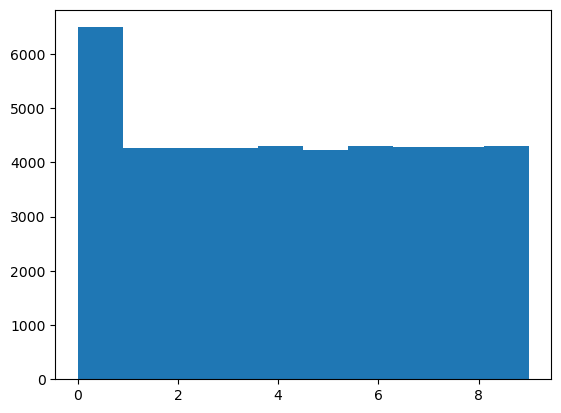

In [32]:
plt.hist(keep_lbls)